In [2]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving a multimaterial model.

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [5]:
from mesher import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './MultiMat.med')

Loaded SALOME .med mesh: 861 nodes, 980 elements
Node groups (4): ['left_e', 'right_e', 'bottom_e', 'top_e']
Element groups (14): ['GR_1_all', 'GR_1_bot_s', 'all', 'bot_s', 'GR_1_top_s', 'top_s', 'GR_1_top_e', 'top_e', 'GR_1_bottom_e', 'bottom_e', 'GR_1_right_e', 'right_e', 'GR_1_left_e', 'left_e']


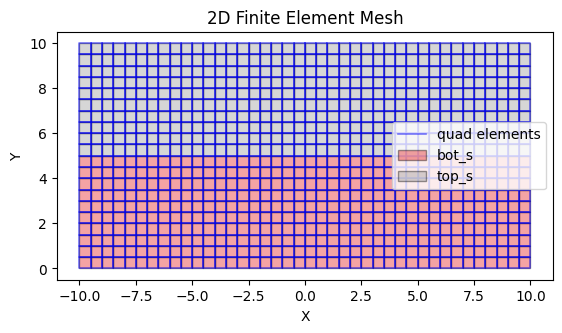

In [ ]:
mesh.plot(show_nodes=False, element_groups_to_plot=['bot_s','top_s'])

### Dirichlet boundary conditions

In [6]:
from solver import BoundaryCondition

bcs = {
        'left_e': BoundaryCondition(dof=1, value=0.0),      
        'right_e': BoundaryCondition(dof=1, value=0.0),
        'bottom_e': BoundaryCondition(dof=2, value=0.0),
        }

### Define material

In [7]:
from materials import LinearElastic

mat1 = LinearElastic(emod = 30*1e6, nu = 0.40)
mat2 = LinearElastic(emod = 50*1e6, nu = 0.30)

matfield = {'top_s': mat1, 
            'bot_s': mat2}

### von Neumman boundary conditions

In [38]:
from solver import LineLoad

compresion = {
            'top_e': LineLoad(fx = 0.0, fy = -2*1e6, reference = "global"),
            }


### Model

In [39]:
from solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      line_loads = compresion,
                      verbose = True
                      )



[matfld] Assigned: ['top_s', 'bot_s']
[matfld] All 800 quad elements have assigned material
[line_load] Applied 1 line load groups
[BC] Processed 3 Dirichlet condition(s) → 83 total constraint(s)
[BC] Applied Dirichlet BCs → 83 fixed DOFs


In [40]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 1.78e-14  Energetic error: -4.37e-08
Iter   2 | du error: 8.94e-15  Res error: 6.03e-15  Energetic error: -5.46e-24
Converged in 2 iterations


In [41]:
fem_solver.udisp

tensor([-2.0234e-17, -1.4857e-01,  5.9013e-18,  ..., -1.6413e-01,
         1.2864e-17, -1.6413e-01])

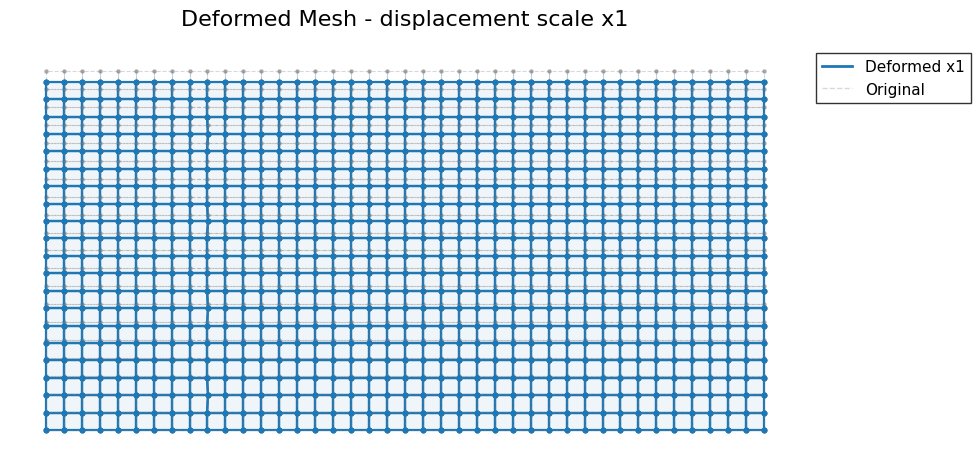

In [46]:
fem_solver.plot_deformed_mesh(scale=1)

In [47]:
from solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    line_loads = compresion,
    verbose=False,
    nnet = mFCNet(num_layers=3, num_neurons=128),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

In [48]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [49]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   lbfgs_epochs = 100,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
Warmup loss: 1.57e-05
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 2.09e-02

Epoch 1/100 (L-BFGS)
Total Loss: 3.386e+00
  Domain: 6.444e-01
  BC:     2.741e+00

Epoch 10/100 (L-BFGS)
Total Loss: 1.932e-02
  Domain: 1.587e-02
  BC:     3.457e-03

Epoch 20/100 (L-BFGS)
Total Loss: 2.691e-03
  Domain: 2.502e-03
  BC:     1.897e-04

Epoch 30/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097e-03
  BC:     1.277e-04

Epoch 40/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097e-03
  BC:     1.277e-04

Epoch 50/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097e-03
  BC:     1.277e-04

Epoch 60/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097e-03
  BC:     1.277e-04

Epoch 70/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097e-03
  BC:     1.277e-04

Epoch 80/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097e-03
  BC:     1.277e-04

Epoch 90/100 (L-BFGS)
Total Loss: 2.225e-03
  Domain: 2.097

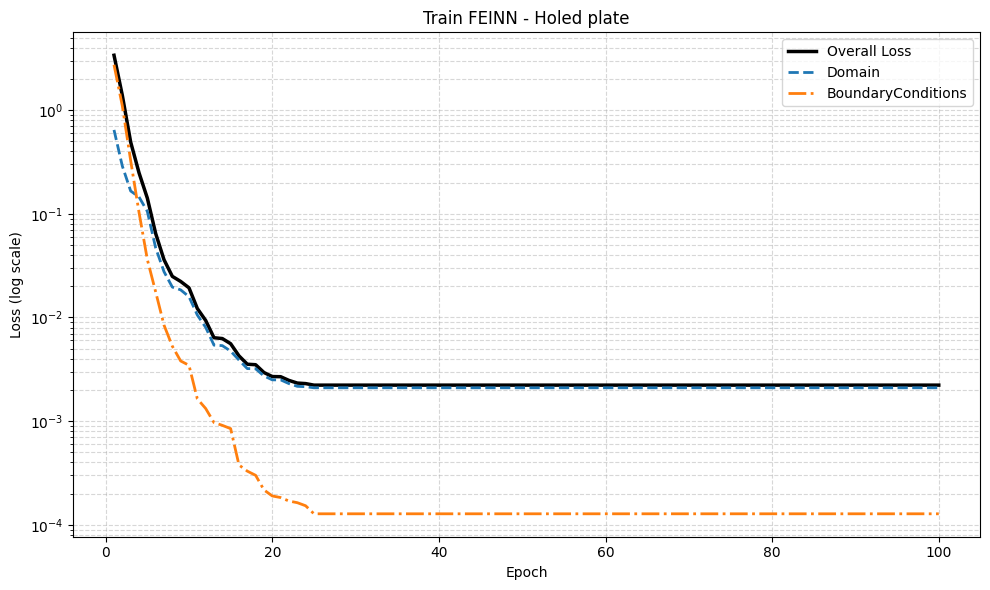

In [50]:
feinn_solver.plot_history(title="Train FEINN - Holed plate")

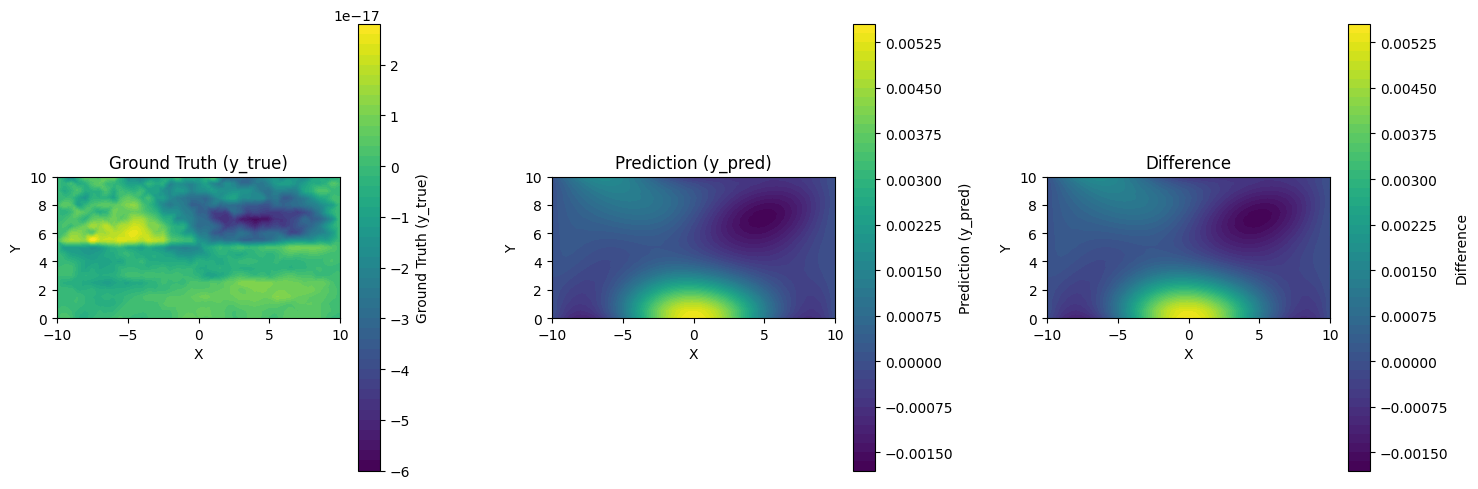

In [51]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

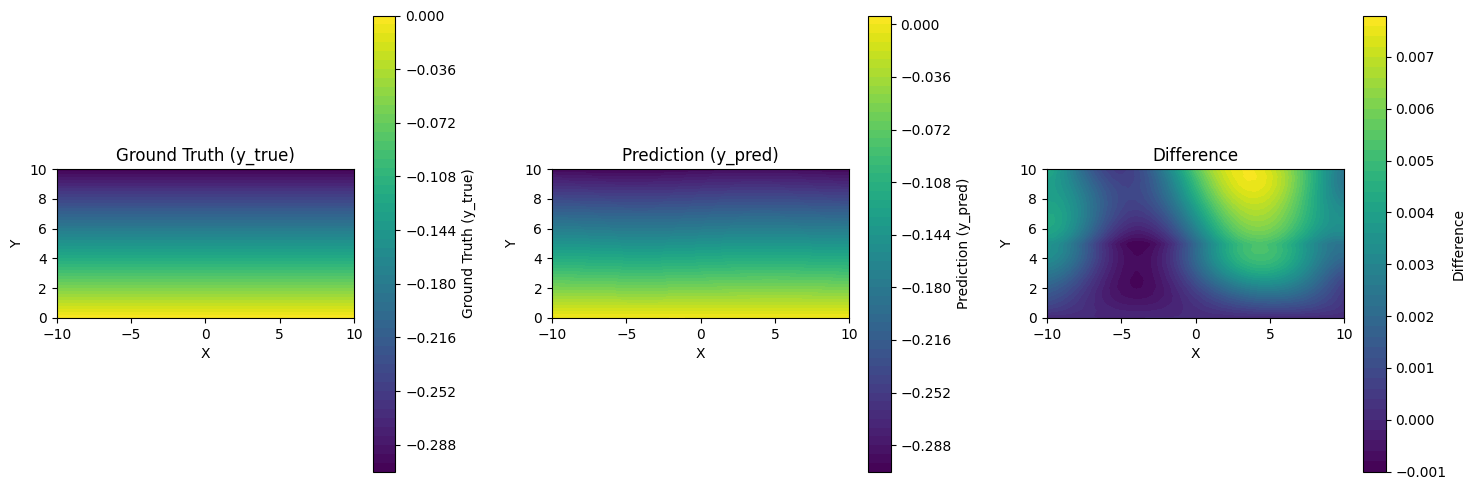

In [52]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')